In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

2023-08-10 09:47:02.267802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/workspace/nlp/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
len(train_dataset), len(test_dataset)

2023-08-10 09:47:09.185176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6638 MB memory:  -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:3f:00.0, compute capability: 7.5


(25000, 25000)

In [24]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
   

In [3]:
for input, label in dataset['test']:
    print(label)
    print(input) 
    break

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), 

2023-08-10 09:47:09.624946: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:
train_sentences = []
train_labels = []
test_sentences = []
test_labels = []

for sent, label in train_dataset:
    train_sentences.append(str(sent.numpy()))
    train_labels.append(label.numpy())
for sent, label in test_dataset:
    test_sentences.append(str(sent.numpy()))
    test_labels.append(label.numpy())

train_labels[-1], train_sentences[-1], test_labels[-1], test_sentences[-1]

(1,
 'b\'First of all, Riget is wonderful. Good comedy and mystery thriller at the same time. Nice combination of strange \\\'dogma\\\' style of telling the story together with good music and great actors. But unfortunately there\\\'s no \\\'the end\\\'. As for me it\\\'s unacceptable. I was thinking... how it will be possible to continue the story without Helmer and Drusse? ...and I have some idea. I think Lars should make RIGET III a little bit different. I\\\'m sure that 3rd part without Helmer wouldn\\\'t be the same. So here\\\'s my suggestion. Mayble little bit stupid, maybe not. I know that Lars likes to experiment. So why not to make small experiment with Riget3? I think the only solution here is to create puppet-driven animation (like for example "team America" by Trey Parker) or even computer 3d animation. I know it\\\'s not the same as real actors, but in principle I believe it could work... only this way it\\\'s possible to make actors alive again. For Riget fans this shoul

In [5]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

train_labels.shape, test_labels.shape

((25000,), (25000,))

In [6]:
vocab_size = 10_000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences)

In [43]:
tokenizer.index_word[len(tokenizer.index_word)]

'slaj'

In [26]:
tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'a': 4,
 'of': 5,
 'to': 6,
 'is': 7,
 'br': 8,
 'in': 9,
 'it': 10,
 'i': 11,
 'this': 12,
 'that': 13,
 'was': 14,
 'as': 15,
 'for': 16,
 'with': 17,
 'movie': 18,
 'but': 19,
 'film': 20,
 "'s": 21,
 'on': 22,
 'you': 23,
 'not': 24,
 'are': 25,
 'his': 26,
 'he': 27,
 'have': 28,
 'be': 29,
 'one': 30,
 'all': 31,
 'at': 32,
 'by': 33,
 'they': 34,
 'an': 35,
 'who': 36,
 'so': 37,
 'from': 38,
 'like': 39,
 'her': 40,
 "'t": 41,
 'or': 42,
 'just': 43,
 'there': 44,
 'about': 45,
 'out': 46,
 "'": 47,
 'has': 48,
 'if': 49,
 'some': 50,
 'what': 51,
 'good': 52,
 'more': 53,
 'very': 54,
 'when': 55,
 'she': 56,
 'up': 57,
 'can': 58,
 'b': 59,
 'time': 60,
 'no': 61,
 'even': 62,
 'my': 63,
 'would': 64,
 'which': 65,
 'story': 66,
 'only': 67,
 'really': 68,
 'see': 69,
 'their': 70,
 'had': 71,
 'were': 72,
 'me': 73,
 'well': 74,
 'we': 75,
 'than': 76,
 'much': 77,
 'been': 78,
 'get': 79,
 'bad': 80,
 'will': 81,
 'people': 82,
 'do': 83,

In [7]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
print(len(train_sequences[0]), train_sequences[0])
print(len(test_sequences[0]), test_sequences[0])

118 [59, 12, 14, 35, 439, 400, 18, 174, 29, 1, 9, 33, 1378, 3401, 42, 496, 1, 197, 25, 88, 156, 19, 12, 211, 340, 29, 70, 248, 213, 9, 486, 62, 70, 88, 116, 99, 24, 5740, 12, 3317, 657, 777, 12, 18, 7, 35, 406, 8228, 178, 2477, 426, 2, 92, 1253, 140, 72, 149, 55, 2, 1, 7525, 72, 229, 70, 2962, 16, 1, 2880, 1, 1, 1506, 4998, 3, 40, 3947, 119, 1608, 17, 3401, 14, 163, 19, 4, 1253, 927, 7986, 9, 4, 18, 13, 14, 4200, 5, 102, 148, 1237, 11, 240, 692, 13, 44, 25, 101, 39, 12, 7232, 1, 39, 1378, 1, 52, 409, 11, 99, 1214, 874, 145, 10]
173 [59, 44, 25, 109, 13, 97, 4115, 16, 742, 4370, 10, 14, 316, 5, 2, 593, 354, 16, 1864, 1212, 1, 16, 680, 7499, 5595, 1, 773, 6, 13, 1037, 1, 1, 439, 491, 1, 4, 1, 334, 3610, 20, 229, 3, 15, 5796, 3, 15, 1646, 15, 102, 5, 2, 3597, 101, 11, 1450, 1528, 12, 251, 235, 11, 216, 2, 377, 6429, 3, 62, 95, 11, 174, 105, 11, 1528, 180, 12, 251, 37, 6, 1144, 1, 682, 7, 4452, 1, 4, 1, 334, 7, 37, 8367, 377, 5, 1420, 1, 13, 30, 64, 28, 6, 874, 181, 17, 4, 1050, 5, 12, 224

In [28]:
print(max([len(s) for s in train_sequences] + [len(s) for s in test_sequences]))
print(min([len(s) for s in train_sequences] + [len(s) for s in test_sequences]))

2527
7


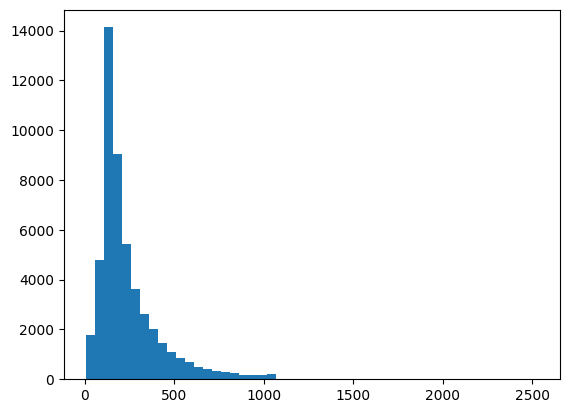

In [29]:
plt.hist([len(s) for s in train_sequences] + [len(s) for s in test_sequences], bins=50)
plt.show()

In [10]:
max_length = 150
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating='post', padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating='post', padding='post')

train_padded.shape, train_padded[0], test_padded.shape, test_padded[0]

((25000, 150),
 array([  59,   12,   14,   35,  439,  400,   18,  174,   29,    1,    9,
          33, 1378, 3401,   42,  496,    1,  197,   25,   88,  156,   19,
          12,  211,  340,   29,   70,  248,  213,    9,  486,   62,   70,
          88,  116,   99,   24, 5740,   12, 3317,  657,  777,   12,   18,
           7,   35,  406, 8228,  178, 2477,  426,    2,   92, 1253,  140,
          72,  149,   55,    2,    1, 7525,   72,  229,   70, 2962,   16,
           1, 2880,    1,    1, 1506, 4998,    3,   40, 3947,  119, 1608,
          17, 3401,   14,  163,   19,    4, 1253,  927, 7986,    9,    4,
          18,   13,   14, 4200,    5,  102,  148, 1237,   11,  240,  692,
          13,   44,   25,  101,   39,   12, 7232,    1,   39, 1378,    1,
          52,  409,   11,   99, 1214,  874,  145,   10,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [11]:
reverse_word_index = dict([(index, word) for (word, index) in tokenizer.word_index.items()])
reverse_word_index

{1: '<OOV>',
 2: 'the',
 3: 'and',
 4: 'a',
 5: 'of',
 6: 'to',
 7: 'is',
 8: 'br',
 9: 'in',
 10: 'it',
 11: 'i',
 12: 'this',
 13: 'that',
 14: 'was',
 15: 'as',
 16: 'for',
 17: 'with',
 18: 'movie',
 19: 'but',
 20: 'film',
 21: "'s",
 22: 'on',
 23: 'you',
 24: 'not',
 25: 'are',
 26: 'his',
 27: 'he',
 28: 'have',
 29: 'be',
 30: 'one',
 31: 'all',
 32: 'at',
 33: 'by',
 34: 'they',
 35: 'an',
 36: 'who',
 37: 'so',
 38: 'from',
 39: 'like',
 40: 'her',
 41: "'t",
 42: 'or',
 43: 'just',
 44: 'there',
 45: 'about',
 46: 'out',
 47: "'",
 48: 'has',
 49: 'if',
 50: 'some',
 51: 'what',
 52: 'good',
 53: 'more',
 54: 'very',
 55: 'when',
 56: 'she',
 57: 'up',
 58: 'can',
 59: 'b',
 60: 'time',
 61: 'no',
 62: 'even',
 63: 'my',
 64: 'would',
 65: 'which',
 66: 'story',
 67: 'only',
 68: 'really',
 69: 'see',
 70: 'their',
 71: 'had',
 72: 'were',
 73: 'me',
 74: 'well',
 75: 'we',
 76: 'than',
 77: 'much',
 78: 'been',
 79: 'get',
 80: 'bad',
 81: 'will',
 82: 'people',
 83: 'do',

In [12]:
def decode_review(sequence):
    return ' '.join([tokenizer.index_word.get(i, '<pad>') for i in sequence])

In [13]:
print(decode_review(train_padded[0]))
print()
print(train_sentences[0])

b this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining <OOV> like christopher <OOV> good name i could barely sit through it <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but 

In [35]:
print(decode_review(train_padded[5]))
print()
print(train_sentences[5])

b this is a film which should be seen by anybody interested in <OOV> by or suffering from an eating disorder it is an amazingly accurate and sensitive portrayal of <OOV> in a teenage girl its causes and its <OOV> the girl is played by one of the most brilliant young actresses working in cinema today alison <OOV> who was later so spectacular in <OOV> the truth <OOV> i would recommend that this film be shown in all schools as you will never see a better on this subject alison <OOV> is absolutely outstanding and one <OOV> at her ability to convey the anguish of a girl suffering from this <OOV> disorder if <OOV> tell us the air pressure alison <OOV> tells us the emotional pressure with the same degree of accuracy her emotional range is so precise each scene could be <OOV> <OOV> for its <OOV> of trauma on

b"This is a film which should be seen by anybody interested in, effected by, or suffering from an eating disorder. It is an amazingly accurate and sensitive portrayal of bulimia in a teen

In [14]:
model = Sequential([
    Embedding(vocab_size+1, 64),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640064    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714433 (2.73 MB)
Trainable params: 714433 (2.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
%%time
num_epochs = 30
history = model.fit(
    train_padded,
    train_labels,
    epochs=num_epochs,
    batch_size=128,
    validation_data=(test_padded, test_labels),
    verbose=1
)

Epoch 1/30


2023-08-10 10:03:39.458805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-10 10:03:39.694320: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5563a6a49b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-10 10:03:39.694385: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-08-10 10:03:39.705402: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-10 10:03:40.205012: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 [==============================] - 51s 231ms/step - loss: 0.4769 - accuracy: 0.7532 - val_loss: 0.3714 - val_accuracy: 0.8419
Epoch 2/30
196/196 [==============================] - 25s 125ms/step - loss: 0.2752 - accuracy: 0.8930 - val_loss: 0.3867 - val_accuracy: 0.8384
Epoch 3/30
196/196 [==============================] - 18s 94ms/step - loss: 0.2132 - accuracy: 0.9204 - val_loss: 0.4255 - val_accuracy: 0.8301
Epoch 4/30
196/196 [==============================] - 15s 76ms/step - loss: 0.1696 - accuracy: 0.9394 - val_loss: 0.4775 - val_accuracy: 0.8162
Epoch 5/30
196/196 [==============================] - 12s 61ms/step - loss: 0.1383 - accuracy: 0.9513 - val_loss: 0.5020 - val_accuracy: 0.8170
Epoch 6/30
196/196 [==============================] - 12s 59ms/step - loss: 0.1163 - accuracy: 0.9618 - val_loss: 0.6631 - val_accuracy: 0.8010
Epoch 7/30
196/196 [==============================] - 11s 53ms/step - loss: 0.0868 - accuracy: 0.9711 - val_loss: 0.6782 - val_accuracy: 0.8169
E

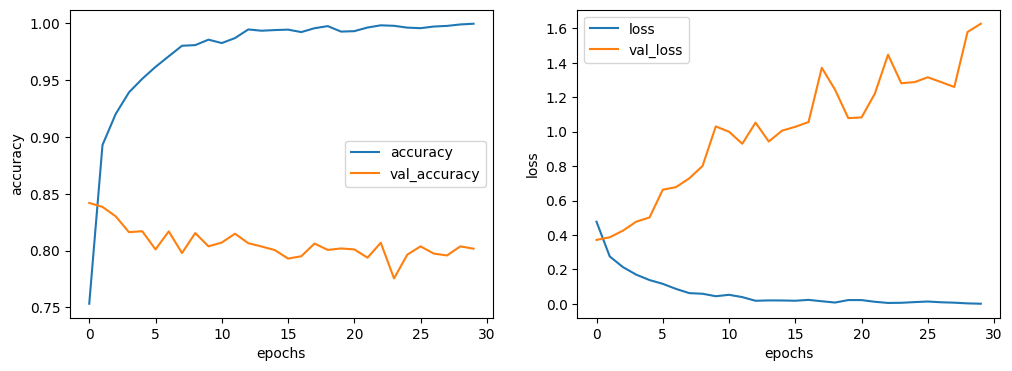

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.legend()
ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()

In [20]:
def predict_text(sample_text):
    sample_seq = tokenizer.texts_to_sequences(sample_text)
    sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post', truncating='post')
    print(sample_padded.shape)
    return model.predict([sample_padded])

In [21]:
sample_text = ['The movie was terrible. I would not recommend the movie.']
predict_text(sample_text)

(1, 150)
1/1 [==============================] - 1s 764ms/step


array([[0.26143843]], dtype=float32)

In [22]:
sample_text = ['The movie was fantastic. I would recommend the movie.']
predict_text(sample_text)

(1, 150)
1/1 [==============================] - 0s 37ms/step


array([[0.9857802]], dtype=float32)

In [23]:
sample_text = ['The animation and graphics were out of this world.']
predict_text(sample_text)

(1, 150)
1/1 [==============================] - 0s 36ms/step


array([[0.9992644]], dtype=float32)